In [1]:
import numpy as np
import matplotlib.pyplot as plt

import snntorch as snn
from snntorch import spikeplot as splt
from snntorch import functional as SF
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import torch
from torch.utils.data import Dataset, DataLoader

from tqdm import tqdm 

import warnings # highly illegal move to make pandas compliant
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
import sys
sys.path.append('../code/utils')  # Add the utils directory to the Python path

import utils_data, utils_spikes, utils_events
import utils_tensor

# And now that we have a dataloader, let's try to fit it using a simple SNN model

In [3]:
# Experiment specific parameters 
chip_id = 9501 # experiment ID
chip_session = 0 # 2 for post-training, 0 for pre-training

# Stable parameters
data_path = '../data/cortical_labs_data/' # path to data
fs = 20000 # sampling frequency
binsize = 10 # ms, bin size for spike counts
array_size = 1024 # number of electrode in the array

# Using our brand new dataloader

Loading data...: 100%|██████████| 29/29 [00:01<00:00, 28.81it/s]


Stimulation mode: full game


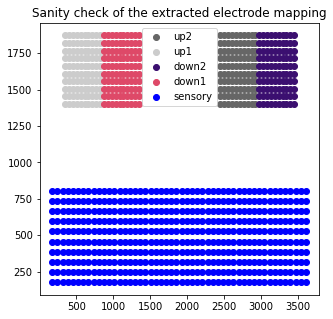

Binning sensory channels: 100%|██████████| 500/500 [00:00<00:00, 537.09it/s]
c:\Users\skorm\Documents\GitHub\BrainDishSiMulator\notebooks\../code/utils\utils_tensor.py:18: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:204.)
  return torch.tensor(binned_spikes)
Binning down2 channels: 100%|██████████| 100/100 [00:00<00:00, 518.02it/s]


True

In [4]:
data_subset, events = utils_data.load_file(chip_id, chip_session, data_path)
spiketimes = utils_data.get_spiketimes(data_subset, array_size,fs)
sensory_spikes, up1_spikes, up2_spikes, down1_spikes, down2_spikes = utils_data.get_electrode_regions(data_subset, spiketimes, do_plot = True)

all_spikes = [sensory_spikes, up1_spikes, up2_spikes, down1_spikes, down2_spikes]
# Find maximum time across all spike lists
max_time_ms = max(max(max(spikes) for spikes in spike_list)*1000 for spike_list in all_spikes)

# Create binned spikes tensor for each region
sensory_spikes_binned = utils_tensor.spike_times_to_bins(sensory_spikes, binsize, max_time_ms, spike_tag = 'sensory')
up1_spikes_binned = utils_tensor.spike_times_to_bins(up1_spikes, binsize, max_time_ms, spike_tag = 'up1')
down1_spikes_binned = utils_tensor.spike_times_to_bins(down1_spikes, binsize, max_time_ms, spike_tag='down1')
up2_spikes_binned = utils_tensor.spike_times_to_bins(up2_spikes, binsize, max_time_ms, spike_tag = 'up2')
down2_spikes_binned = utils_tensor.spike_times_to_bins(down2_spikes, binsize, max_time_ms, spike_tag = 'down2')

# Verifying that the tensor are binary files
utils_tensor.check_binary(sensory_spikes_binned, "sensory_spikes_binned")
utils_tensor.check_binary(up1_spikes_binned, "up1_spikes_binned")
utils_tensor.check_binary(down1_spikes_binned, "down1_spikes_binned")
utils_tensor.check_binary(up2_spikes_binned, "up2_spikes_binned")
utils_tensor.check_binary(down2_spikes_binned, "down2_spikes_binned")

# And now we fit using SNNTorch, using a pipeline courtesy of Jason Eshraghian

### First we need to get some labels

In [5]:
def events_to_bins(events, event_types, bin_width, max_time_ms):
    num_bins = int(np.ceil(max_time_ms / bin_width))
    event_bins = np.zeros((len(event_types), num_bins))
    event_index = 0  # pointer to track current event
    
    # sort events based on 'norm_timestamp'
    events = sorted(events, key=lambda e: e['norm_timestamp'])

    for bin_index in range(num_bins):
        current_bin_time = bin_width * bin_index
        next_bin_time = bin_width * (bin_index + 1)

        # move the event pointer until an event is in the future
        while event_index < len(events) and events[event_index]['norm_timestamp'] < next_bin_time:
            curr_event = events[event_index]['event']
            curr_event_type_index = event_types.index(curr_event)
            event_bins[curr_event_type_index, bin_index] = 1
            event_index += 1

    return event_bins

In [6]:
# Process everything so its nice and milliseconds
events[0]['event'] = 'motor layout: 0' # change the being game to motor layout for convenience 

# First we need to label the data 
for event in events:
    event['norm_timestamp'] /= fs  # fs to seconds 
    event['norm_timestamp'] *= 1000  # seconds to ms
    
event_types = ['ball missed', 'ball bounce', 'ball return', 'motor layout: 0'] # these are all the labels
labels = torch.tensor(events_to_bins(events, event_types, 10, max_time_ms))

In [7]:
print(labels.shape) # torch.Size([4, 120002]) - 4 labels, 120002 time bins
print(up1_spikes_binned.shape) # torch.Size([100, 120002]) - 100 neurons, 120002 time bins

torch.Size([4, 120002])
torch.Size([100, 120002])


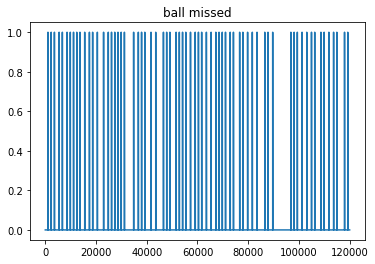

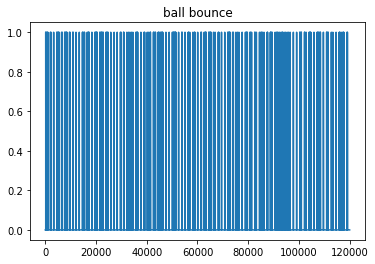

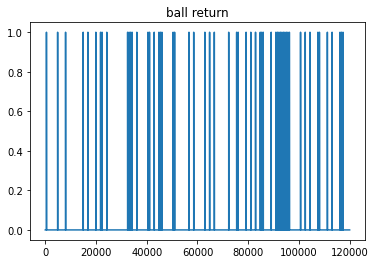

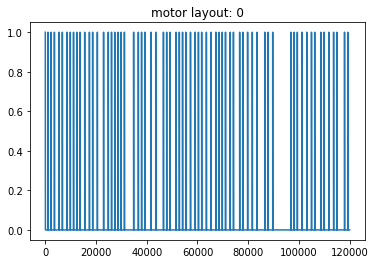

In [8]:
# Plot each label row in a different plot 
for i in range(labels.shape[0]):
    plt.figure()
    plt.plot(labels[i,:])
    plt.title(event_types[i])
    plt.show()

In [9]:
print(len(sorted(torch.where(labels ==1)[1])))

418


In [10]:
def transform_data(labels, spikes, len_trial) :
    all_onsets = []
    for irowlabel in range(labels.shape[0]) :
        onsets = np.where(labels[irowlabel,:]==1)[0]
        all_onsets.append([(x, irowlabel) for x in onsets])
        
    sorted_onsets = sorted([x for sublist in all_onsets for x in sublist], key=lambda x: x[0])

    transformed_data = np.zeros((len_trial, len(sorted_onsets), spikes.shape[0]))
    transformed_labels = np.zeros((len(sorted_onsets)))
    for ionset, onset in enumerate(sorted_onsets) :
        onset_time = onset[0]
        onset_label = onset[1]
        onset_spikes = spikes[:,onset_time:onset_time+len_trial].swapaxes(0,1)
        transformed_data[:,ionset,:] = onset_spikes
        transformed_labels[ionset] = onset_label
        
    return transformed_data, transformed_labels

transformed_data, transformed_labels = transform_data(labels, sensory_spikes_binned, 100)

In [11]:
print(transformed_data.shape)
print(transformed_labels.shape)

(100, 418, 500)
(418,)


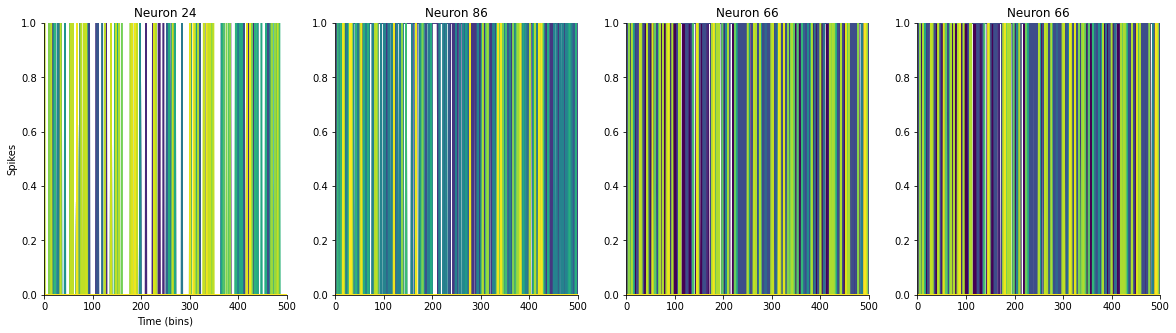

In [12]:
n_rand_neurons = 4 

fig, axs = plt.subplots(ncols = n_rand_neurons, figsize = (5*n_rand_neurons,5))

cmap = plt.cm.viridis(np.linspace(0,1,transformed_data.shape[1]))
for irand, rand in enumerate(range(n_rand_neurons)):
    rand_neuron = np.random.randint(0, transformed_data.shape[0])
    
    for itrial in range(transformed_data.shape[1]):
        axs[irand].plot(transformed_data[rand_neuron, itrial, :], color = cmap[itrial])
    axs[irand].set_title('Neuron {}'.format(rand_neuron))
    axs[irand].spines[['top', 'right']].set_visible(False)
    axs[irand].set_xlim(0, transformed_data.shape[-1])
    axs[irand].set_ylim(0, 1)
    if irand == 0 :
        axs[irand].set_xlabel('Time (bins)')
        axs[irand].set_ylabel('Spikes')
plt.show()

### And now we can define the network, based on [Jason's colab notebook](https://colab.research.google.com/drive/1VlFTwmj9_4_Fyl542nNNFvy4RPq39f5p?usp=sharing#scrollTo=lIsz8d1JiQxz)

In [13]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [14]:
print(transformed_data.shape)
print(transformed_labels.shape)

(100, 418, 500)
(418,)


In [15]:
class CustomDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return torch.tensor(self.data[:, idx, :], dtype=torch.float32), torch.tensor(self.labels[idx], dtype=torch.long)

# Create Dataset
dataset = CustomDataset(transformed_data, transformed_labels)

# Create DataLoader
data_loader = DataLoader(dataset, batch_size=32, shuffle=True)  # Change batch_size as needed

In [16]:
# Define Network
class Net(nn.Module):
    def __init__(self):
        super().__init__()

        num_inputs = 500
        num_hidden = 1000
        num_outputs = 4
        beta = 0.95

        # Initialize layers
        self.fc1 = nn.Linear(num_inputs, num_hidden)
        self.lif1 = snn.Leaky(beta=beta)
        self.fc2 = nn.Linear(num_hidden, num_outputs)
        self.lif2 = snn.Leaky(beta=beta)

    def forward(self, x):
        # Initialize hidden states at t=0
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()

        # Record the final layer
        spk2_rec = []
        mem2_rec = []

        for step in range(x.size(1)):
            cur1 = self.fc1(x[:,step])
            spk1, mem1 = self.lif1(cur1, mem1)
            cur2 = self.fc2(spk1)
            spk2, mem2 = self.lif2(cur2, mem2)
            spk2_rec.append(spk2)
            mem2_rec.append(mem2)

        return torch.stack(spk2_rec, dim=0), torch.stack(mem2_rec, dim=0)

# Load the network onto CUDA if available
brain_net = Net().to(device)

In [17]:
loss_fn = SF.ce_count_loss()
optimizer = torch.optim.Adam(brain_net.parameters(), lr=1e-3, betas=(0.9, 0.999))

num_epochs = 10
loss_hist = []
test_loss_hist = []
counter = 0

# Outer training loop
for epoch in range(num_epochs):
    train_batch = iter(data_loader)

    # Minibatch training loop
    for data, targets in train_batch:
        data = data.to(device)
        targets = targets.to(device)

        # forward pass
        brain_net.train()
        spk_rec, _ = brain_net(data)

        # initialize the loss & sum over time
        loss_val = loss_fn(spk_rec, targets)

        # Gradient calculation + weight update
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

        # Store loss history for future plotting
        loss_hist.append(loss_val.item())

        # Print train/test loss/accuracy
        if counter % 10 == 0:
            print(f"Iteration: {counter} \t Train Loss: {loss_val.item()}")
        counter += 1

        if counter == 100:
            break

C:\Users\skorm\AppData\Local\Temp\ipykernel_27020\2140556988.py:10: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  return torch.tensor(self.data[:, idx, :], dtype=torch.float32), torch.tensor(self.labels[idx], dtype=torch.long)


Iteration: 0 	 Train Loss: 1.3862946033477783
Iteration: 10 	 Train Loss: 1.3862946033477783
Iteration: 20 	 Train Loss: 1.3114358186721802
Iteration: 30 	 Train Loss: 1.1973860263824463
Iteration: 40 	 Train Loss: 1.2900372743606567
Iteration: 50 	 Train Loss: 1.10379958152771
Iteration: 60 	 Train Loss: 1.2667336463928223
Iteration: 70 	 Train Loss: 1.0226351022720337
Iteration: 80 	 Train Loss: 1.103960394859314
Iteration: 90 	 Train Loss: 0.9411011338233948
Iteration: 100 	 Train Loss: 0.8858334422111511
Iteration: 110 	 Train Loss: 1.138201355934143
Iteration: 120 	 Train Loss: 1.2112789154052734


In [18]:
# todo sweep lr, beta, threshold
# depth, width